# Kadir Berat YILDIRIM

## Reports from Wandb

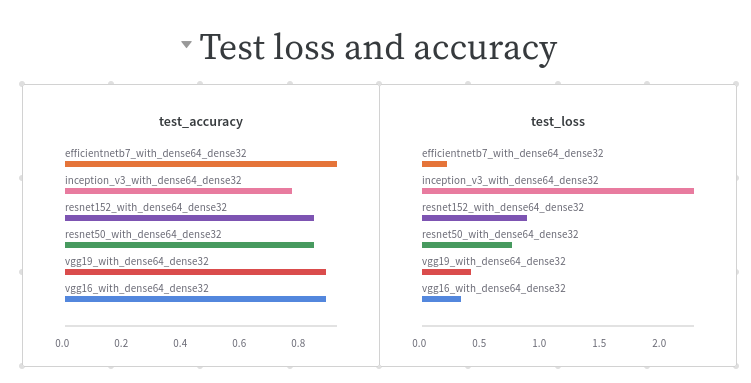

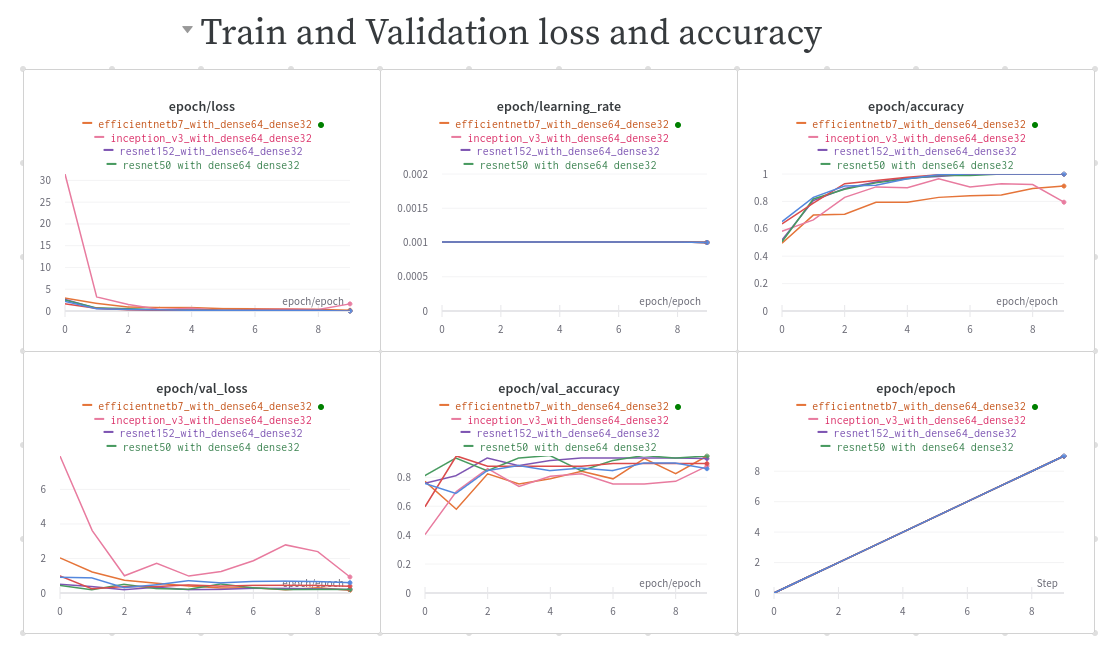

I write a method below that takes a base model as input and adds custom layers, then evaluates it with a given data while also logging to wandb.ai.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

IMG_PATH = 'brain_tumor_dataset/'

all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

labels = [1 if 'Y' in filename else 0 for filename in all_images]

X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 170
Validation set size: 57
Test set size: 26


# Convert Data to Numpy

In [3]:
def open_images(paths, img_size = 128):
    from tensorflow.keras.preprocessing.image import load_img
    
    images = []
    for path in paths:
        image = load_img(path, target_size = (img_size, img_size))
        images.append(image)
    return np.array(images)

X_train = open_images(X_train)
X_val = open_images(X_val)
X_test = open_images(X_test)

X_train = np.array([np.array(i) for i in X_train])
X_val = np.array([np.array(i) for i in X_val])
X_test = np.array([np.array(i) for i in X_test])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

2023-04-16 00:32:02.132142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model

This is a method to create and evaluate the model with a given base model.

I take the base model, add custom layers to it, then evaluate it using the given dataset while logging to wandb.

In [7]:
def transfer_model(base, data):
    X_train, X_val, X_test, y_train, y_val, y_test = data
    
    base.trainable = False

    model = Sequential([
        base,
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    wandb.init(
        project="Transfer Learning",
        name=base.name+'_with_dense64_dense32',
        config={ 
        "architecture": "CNN", 
        "dataset": "brain tumor dataset", 
        "epochs": 10,
        "Dense activations": "Relu",
        "Loss": "binary_crossentropy"
        } 
    )

    model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), callbacks=[WandbMetricsLogger()])
    
    score = model.evaluate(X_test, y_test, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})

# Transfer Learning Models

In a for loop, I use the method above with 6 different pre-trained models taken from keras.

In [8]:
from keras.layers import Dense, Flatten
from keras.models import Sequential
import wandb 
from wandb.keras import WandbMetricsLogger

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB7

base_models = [
    VGG16(weights = "imagenet", include_top = False, input_shape = X_train.shape[1:]),
    VGG19(weights = "imagenet", include_top = False, input_shape = X_train.shape[1:]),
    ResNet50(weights = "imagenet", include_top = False, input_shape = X_train.shape[1:]),
    ResNet152(weights = "imagenet", include_top = False, input_shape = X_train.shape[1:]),
    InceptionV3(weights = "imagenet", include_top = False, input_shape = X_train.shape[1:]),
    EfficientNetB7(weights = "imagenet", include_top = False, input_shape = X_train.shape[1:])
]

for model in base_models:
    transfer_model(model, [X_train, X_val, X_test, y_train, y_val, y_test])

2023-04-16 00:40:21.793125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 00:40:21.795512: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
wandb: Currently logged in as: kadirberatyildirim (mimlab). Use `wandb login --relogin` to force relogin


Epoch 1/10
6/6 [==============================] - 6s 1s/step - loss: 2.1484 - accuracy: 0.6529 - val_loss: 0.8807 - val_accuracy: 0.7544
Epoch 2/10
6/6 [==============================] - 6s 997ms/step - loss: 0.4427 - accuracy: 0.8294 - val_loss: 0.8439 - val_accuracy: 0.6842
Epoch 3/10
6/6 [==============================] - 6s 1s/step - loss: 0.2687 - accuracy: 0.9118 - val_loss: 0.2810 - val_accuracy: 0.8421
Epoch 4/10
6/6 [==============================] - 6s 995ms/step - loss: 0.1771 - accuracy: 0.9176 - val_loss: 0.4412 - val_accuracy: 0.8772
Epoch 5/10
6/6 [==============================] - 6s 993ms/step - loss: 0.0655 - accuracy: 0.9647 - val_loss: 0.6834 - val_accuracy: 0.8421
Epoch 6/10
6/6 [==============================] - 6s 970ms/step - loss: 0.0391 - accuracy: 0.9941 - val_loss: 0.5536 - val_accuracy: 0.8596
Epoch 7/10
6/6 [==============================] - 6s 996ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.6370 - val_accuracy: 0.8421
Epoch 8/10
6/6 [==========

epoch/accuracy,▁▅▆▆▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▃▁▆▇▆▇▆██▇
epoch/val_loss,██▁▃▆▄▅▅▅▅
test_accuracy,▁
test_loss,▁
epoch/accuracy,1.0
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 1.5698 - accuracy: 0.6353 - val_loss: 0.9730 - val_accuracy: 0.5965
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.5203 - accuracy: 0.7882 - val_loss: 0.2194 - val_accuracy: 0.9474
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.1900 - accuracy: 0.9294 - val_loss: 0.3458 - val_accuracy: 0.8772
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 0.0855 - accuracy: 0.9529 - val_loss: 0.3453 - val_accuracy: 0.8772
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 0.0464 - accuracy: 0.9765 - val_loss: 0.4422 - val_accuracy: 0.8772
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.0244 - accuracy: 0.9941 - val_loss: 0.3715 - val_accuracy: 0.8772
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.4156 - val_accuracy: 0.8947
Epoch 8/10
6/6 [=========================

epoch/accuracy,▁▄▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁█▇▇▇▇▇▇▇▇
epoch/val_loss,█▁▂▂▃▂▃▃▃▃
test_accuracy,▁
test_loss,▁
epoch/accuracy,1.0
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
6/6 [==============================] - 7s 887ms/step - loss: 2.4380 - accuracy: 0.5059 - val_loss: 0.4157 - val_accuracy: 0.8070
Epoch 2/10
6/6 [==============================] - 4s 692ms/step - loss: 0.6238 - accuracy: 0.8176 - val_loss: 0.1617 - val_accuracy: 0.9298
Epoch 3/10
6/6 [==============================] - 4s 723ms/step - loss: 0.4392 - accuracy: 0.8882 - val_loss: 0.4757 - val_accuracy: 0.8421
Epoch 4/10
6/6 [==============================] - 4s 760ms/step - loss: 0.1800 - accuracy: 0.9353 - val_loss: 0.2295 - val_accuracy: 0.9298
Epoch 5/10
6/6 [==============================] - 4s 763ms/step - loss: 0.1097 - accuracy: 0.9647 - val_loss: 0.1864 - val_accuracy: 0.9474
Epoch 6/10
6/6 [==============================] - 4s 759ms/step - loss: 0.0206 - accuracy: 0.9882 - val_loss: 0.4954 - val_accuracy: 0.8421
Epoch 7/10
6/6 [==============================] - 4s 737ms/step - loss: 0.0302 - accuracy: 0.9882 - val_loss: 0.2734 - val_accuracy: 0.9123
Epoch 8/10
6/6 [====

epoch/accuracy,▁▅▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▇▃▇█▃▆█▇█
epoch/val_loss,▆▁█▂▂█▃▁▁▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,1.0
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
6/6 [==============================] - 16s 2s/step - loss: 2.5822 - accuracy: 0.5176 - val_loss: 0.4839 - val_accuracy: 0.7544
Epoch 2/10
6/6 [==============================] - 8s 1s/step - loss: 0.4905 - accuracy: 0.8059 - val_loss: 0.3505 - val_accuracy: 0.8070
Epoch 3/10
6/6 [==============================] - 9s 2s/step - loss: 0.2540 - accuracy: 0.8941 - val_loss: 0.1690 - val_accuracy: 0.9298
Epoch 4/10
6/6 [==============================] - 9s 2s/step - loss: 0.1273 - accuracy: 0.9412 - val_loss: 0.3098 - val_accuracy: 0.8772
Epoch 5/10
6/6 [==============================] - 9s 2s/step - loss: 0.0726 - accuracy: 0.9706 - val_loss: 0.1714 - val_accuracy: 0.9123
Epoch 6/10
6/6 [==============================] - 9s 2s/step - loss: 0.0464 - accuracy: 0.9824 - val_loss: 0.1884 - val_accuracy: 0.9298
Epoch 7/10
6/6 [==============================] - 9s 2s/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.2502 - val_accuracy: 0.9298
Epoch 8/10
6/6 [========================

epoch/accuracy,▁▅▆▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃█▆▇█████
epoch/val_loss,█▅▁▄▁▁▃▃▂▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,1.0
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
6/6 [==============================] - 7s 610ms/step - loss: 31.4692 - accuracy: 0.5824 - val_loss: 7.9342 - val_accuracy: 0.4035
Epoch 2/10
6/6 [==============================] - 2s 395ms/step - loss: 3.2416 - accuracy: 0.6647 - val_loss: 3.6146 - val_accuracy: 0.7018
Epoch 3/10
6/6 [==============================] - 2s 369ms/step - loss: 1.5087 - accuracy: 0.8294 - val_loss: 0.9977 - val_accuracy: 0.8596
Epoch 4/10
6/6 [==============================] - 2s 439ms/step - loss: 0.3334 - accuracy: 0.9059 - val_loss: 1.7207 - val_accuracy: 0.7368
Epoch 5/10
6/6 [==============================] - 3s 444ms/step - loss: 0.6086 - accuracy: 0.9000 - val_loss: 0.9789 - val_accuracy: 0.8070
Epoch 6/10
6/6 [==============================] - 2s 354ms/step - loss: 0.1069 - accuracy: 0.9647 - val_loss: 1.2405 - val_accuracy: 0.8246
Epoch 7/10
6/6 [==============================] - 2s 392ms/step - loss: 0.3607 - accuracy: 0.9059 - val_loss: 1.8692 - val_accuracy: 0.7544
Epoch 8/10
6/6 [===

epoch/accuracy,▁▃▆▇▇█▇▇▇▅
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅█▆▇▇▆▆▆█
epoch/val_loss,█▄▁▂▁▁▂▃▂▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.79412
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
6/6 [==============================] - 29s 3s/step - loss: 2.8537 - accuracy: 0.4941 - val_loss: 2.0308 - val_accuracy: 0.7719
Epoch 2/10
6/6 [==============================] - 12s 2s/step - loss: 1.6377 - accuracy: 0.7000 - val_loss: 1.2209 - val_accuracy: 0.5789
Epoch 3/10
6/6 [==============================] - 14s 2s/step - loss: 0.7826 - accuracy: 0.7059 - val_loss: 0.7427 - val_accuracy: 0.8246
Epoch 4/10
6/6 [==============================] - 17s 3s/step - loss: 0.6545 - accuracy: 0.7941 - val_loss: 0.5594 - val_accuracy: 0.7544
Epoch 5/10
6/6 [==============================] - 16s 3s/step - loss: 0.6598 - accuracy: 0.7941 - val_loss: 0.4075 - val_accuracy: 0.7895
Epoch 6/10
6/6 [==============================] - 15s 2s/step - loss: 0.4081 - accuracy: 0.8294 - val_loss: 0.2879 - val_accuracy: 0.8421
Epoch 7/10
6/6 [==============================] - 12s 2s/step - loss: 0.3840 - accuracy: 0.8412 - val_loss: 0.3018 - val_accuracy: 0.7895
Epoch 8/10
6/6 [==================